# Supplemental Figure 5A - AIB Dynamics (deltaF)
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 10.12.25


This code will walk through how we find the dynamics of AIB activity by calculating its change in fluorescence (delta F, or dF), and comparing AIB dF dynamics between WT and motor-silenced (nmr-1::HisCl) experiments. This data was shown in supplemental figure 5A. We basically want to compare dynamics of AIB responses in WT vs w/o motor input from AVA.

Feel free to compare dynamics of WT AIB with other silenced experiments, or with other neurons. I'm just demonstrating here what was published.


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [4]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import math
import statistics
import seaborn as sns
import pandas as pd

In [5]:
## Importing Dictionary Datasets ##

# Worm numbers
WT_worm_num = 15
nmrHis_worm_num = 20

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

print("Imported data successfully!")

Imported data successfully!


In [6]:
# Find and return data arrays of interest for each worm, type of trace (raw, background-corrected, or normalized), 
# and experiment (odor, red light, odor+red [named "both"]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out full set of experiments for each neuron (AIB only shown here)
# To pull out other neuron data, replace any instance of AIB with other names (AVA, AIA)

# For deltaF, we need to use background-corrected data,  which are just the raw traces minus background (BG) 

WT_AIB_bgcorr_odor = FindNeurons(WT_dict, "BG Corr", "AIB", "Odor")

WT_AIB_bgcorr_red = FindNeurons(WT_dict, "BG Corr", "AIB", "Red")

WT_AIB_bgcorr_both = FindNeurons(WT_dict, "BG Corr", "AIB", "Both")


# nmr-1::HisCl (motor-silenced) #
nmrHis_AIB_bgcorr_odor = FindNeurons(nmrHis_dict, "BG Corr", "AIB", "Odor")

nmrHis_AIB_bgcorr_red = FindNeurons(nmrHis_dict, "BG Corr", "AIB", "Red")

nmrHis_AIB_bgcorr_both = FindNeurons(nmrHis_dict, "BG Corr", "AIB", "Both")

print("Neurons found")


Neurons found


In [7]:
## - Smoothing Traces - ##

# Smoothing helps to reduce jitter/noise in traces
# Process involves shifting each trace by a certain number of frames (5 seems to be sufficient without 
# over-smoothing), where trace is shifted in the beginning and end by the same number of frames, then 
# averaged with original trace to produce new, smoothed trace. Frame rate is 10fps.

def Smooth(array, shift): # we shift by 5 frames, too much will over-smooth and too little will not reduce noise

    smoothed = [] 
    step = (2*shift) + 1 #total number of arrays from shifting, plus original array
    
    for a in array:
        temp = []

        for i in range(shift): #shift array one at a time
            plus = a[(i+1):]
            plus = np.append(plus, [np.nan]*(i+1)) #add nans at beginning

            minus = a[:-(i+1)]
            minus = np.insert(minus, 0, [np.nan]*(i+1)) #add nans at end

            temp.append(plus) #append beginning-shifted array
            temp.append(minus) #append end-shifted array

        temp.append(a) #append original array

        smooth = np.sum(temp, axis = 0) / step #average all arrays 
        smoothed.append(smooth[shift:-shift]) #cuts off nans in beginning and end generated from shifting
    
    return smoothed


# WT data #
WT_AIB_odor_smooth = Smooth(WT_AIB_bgcorr_odor, 5)
WT_AIB_red_smooth = Smooth(WT_AIB_bgcorr_red, 5)
WT_AIB_both_smooth = Smooth(WT_AIB_bgcorr_both, 5)

# nmr-1::HisCl data #
nmrHis_AIB_odor_smooth = Smooth(nmrHis_AIB_bgcorr_odor, 5)
nmrHis_AIB_red_smooth = Smooth(nmrHis_AIB_bgcorr_red, 5)
nmrHis_AIB_both_smooth = Smooth(nmrHis_AIB_bgcorr_both, 5)

print("Traces smoothed")
#print data above to test

Traces smoothed


In [10]:
## - Delta F data for every worm across a full set of experiments - ##
# (very similar to normalization process in 'Processing Neuron Data (Smoothing and Normalization).ipynb')

# Find change in fluorescence (delta F, or dF) of smoothed, background-corrected data above
# We take dF of worms across a full set of 3 experiments (odor, red light, odor+red light), to fully capture 
# AIB's dynamic range. Because some experiments are designed to not activate certain neurons, and AIB may be 
# less active during those phases in response, if we took the dF of each individual trace, it would appear as 
# noise due to inactivity. 
# We use smoothed traces (above) for dF, again to reduce noise. 
# dF formula: (F - Fmin) / (Fmin) where Fmin/max is the min/max from one set of experiments.

def DeltaF_exps(odor, red, both, cutoff, worms, exps): 
#need to reshape arrays by number of worms and experiments (3)

    dFs = []
    
    for i in range(worms):
        one_exp = np.concatenate((odor[i][cutoff:], red[i][cutoff:], both[i][cutoff:]))
        # We will cut off the first 350 frames, and then will combine the traces so that the 3 experiments are 
        # combined for each worm. 
        mins = np.min(one_exp) # find min across all 3 exps per worm
        maxs = np.max(one_exp) # find max across all 3 exps per worm
        
        for f in one_exp:
            dF = (f - mins)/(mins) # apply dF formula
            dFs.append(dF)
        
    dFs = np.reshape(dFs,(worms*exps,len(odor[0][cutoff:]))) # reshape so that can be separated back into exps

    dF_odor = [] # separate dF traces back into respective exps
    dF_red = [] 
    dF_both = [] 

    for count in range(worms):
        dF_odor.append(dFs[count*3]) # apply count so that odor exps correspond to indices 0, 3, 6, etc
        dF_red.append(dFs[count*3 + 1]) # same as above for indices 1, 4, 7, etc
        dF_both.append(dFs[count*3 + 2]) # same for indices 2, 5, 8, etc
    
    return dF_odor, dF_red, dF_both


# WT data #
WT_worm_num = 15

WT_AIB_dF = DeltaF_exps(WT_AIB_odor_smooth, WT_AIB_red_smooth, WT_AIB_both_smooth, 350, WT_worm_num, 3)

WT_AIB_dF_odor = WT_AIB_dF[0]
WT_AIB_dF_red = WT_AIB_dF[1]
WT_AIB_dF_both = WT_AIB_dF[2]

# nmr-1::HisCl data #
nmrHis_worm_num = 20

nmrHis_AIB_dF = DeltaF_exps(nmrHis_AIB_odor_smooth, nmrHis_AIB_red_smooth, nmrHis_AIB_both_smooth, 350, nmrHis_worm_num, 3)

nmrHis_AIB_dF_odor = nmrHis_AIB_dF[0]
nmrHis_AIB_dF_red = nmrHis_AIB_dF[1]
nmrHis_AIB_dF_both = nmrHis_AIB_dF[2]

print("dF Complete")
#print data above to test

dF Complete


In [33]:
## Ranking dF Traces for Comparison ##

# Within each dF trace, we want to rank their values from lowest to highest change in fluorescence
# Then, take top percentage (we did 10%) of each trace's dF (peak activity), and take the median of this
# Compare WT vs nmrHis worms

def Peak_dF(array, percentage):
    
    peak_dF = []
    
    for a in array:
        length = len(a)
        sort = np.sort(a)
        reverse_sort = sort[::-1]
        peak = np.median(reverse_sort[:int(length/percentage)])
        peak_dF.append(peak)
        
    return peak_dF

peak_dF_WT_AIB_odor = Peak_dF(WT_AIB_dF_odor, 10)
peak_dF_WT_AIB_red = Peak_dF(WT_AIB_dF_red, 10)
peak_dF_WT_AIB_both = Peak_dF(WT_AIB_dF_both, 10)

peak_dF_nmrHis_AIB_odor = Peak_dF(nmrHis_AIB_dF_odor, 10)
peak_dF_nmrHis_AIB_red = Peak_dF(nmrHis_AIB_dF_red, 10)
peak_dF_nmrHis_AIB_both = Peak_dF(nmrHis_AIB_dF_both, 10)

print('Peak dF Found')


Peak dF Found


        WT-o      WT-r      WT-b     nmr-o     nmr-r     nmr-b
0   1.205369  0.887422  0.894142  0.183030  0.788222  0.546444
1   1.754630  1.540996  1.580861  0.290419  0.565910  0.492038
2   1.074564  1.288281  1.237853  0.463230  0.512760  0.517925
3   0.716057  1.660632  1.759337  1.273673  0.852065  0.547803
4   0.344008  0.188366  0.934755  0.640361  0.558061  0.307423
5   2.358126  1.836706  1.283802  0.608722  0.584263  0.344413
6   1.085954  0.485059  2.637648  1.552432  0.755259  0.611949
7   0.286019  0.624370  0.252449  1.036536  0.803254  0.469935
8   1.971667  1.489497  1.491074  0.983356  1.301624  0.578508
9   0.384964  1.696242  2.095801  0.947238  1.156466  0.440632
10  2.665378  3.092239  3.084090  1.295636  1.117681  0.625240
11  1.509304  1.690559  1.472837  1.794277  3.549967  1.482091
12  0.485882  1.880653  2.703603  1.749661  0.706059  0.717520
13  2.736219  1.947884  2.541918  1.008975  0.468356  1.303074
14  1.994873  0.362285  2.462289  0.333403  1.179976  0

(0.0, 4.0)

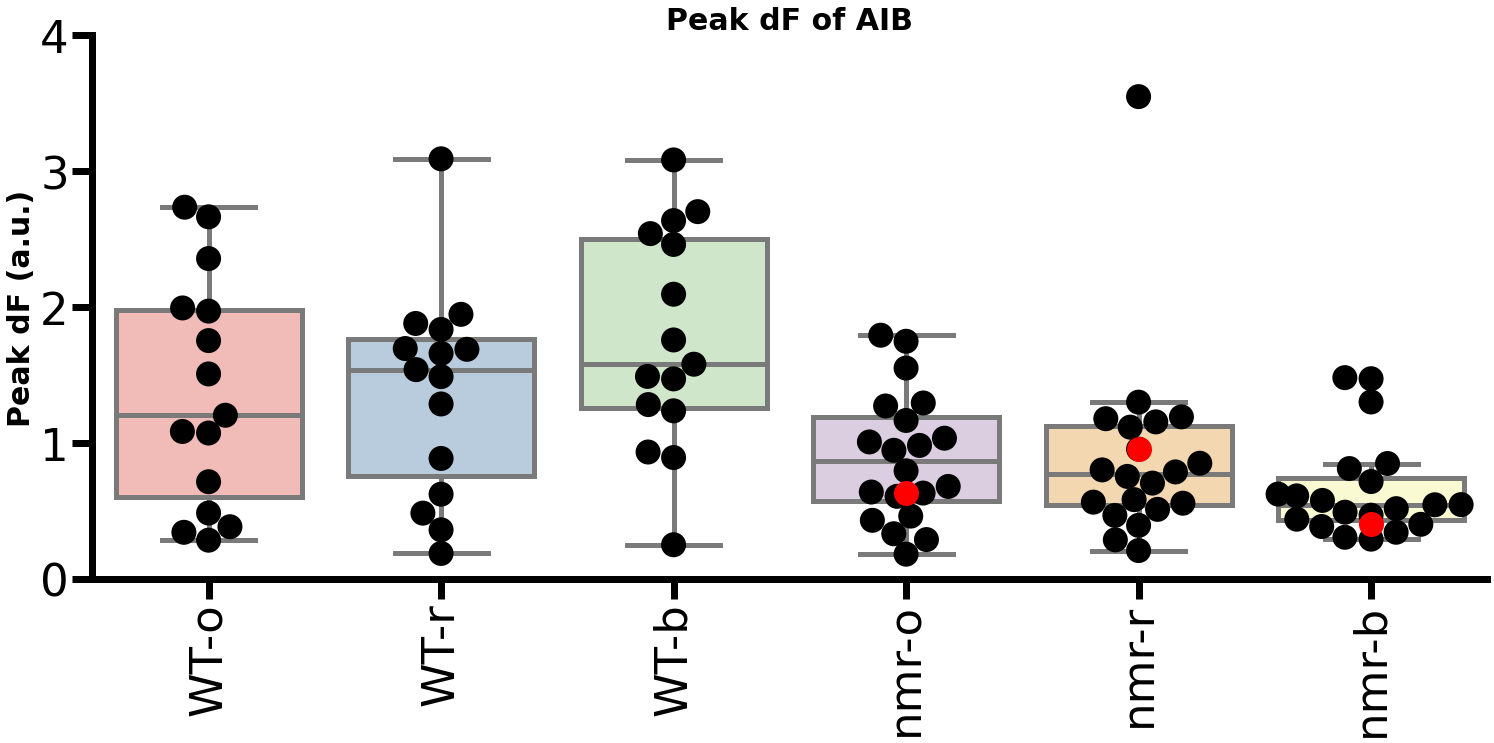

In [34]:
## Plotting out peak dFs for comparison ##

# Note that there are 15 WT worms and 20 nmrHis worms, so we have to pad the WT data with nans to be able to 
# plot them together (nans don't get plotted)

peak_deltas = []

peak_deltas.append(peak_dF_WT_AIB_odor+([np.nan]*5))
peak_deltas.append(peak_dF_WT_AIB_red+([np.nan]*5))
peak_deltas.append(peak_dF_WT_AIB_both+([np.nan]*5))
                   
peak_deltas.append(peak_dF_nmrHis_AIB_odor)
peak_deltas.append(peak_dF_nmrHis_AIB_red)
peak_deltas.append(peak_dF_nmrHis_AIB_both)

peak_deltas_graph = np.reshape(peak_deltas,(6,20))
peak_deltas_graph = peak_deltas_graph.T

peak_deltas_labels = ['WT-o','WT-r', 'WT-b', 'nmr-o', 'nmr-r', 'nmr-b']

dpdf = pd.DataFrame(peak_deltas_graph, columns=peak_deltas_labels)
print(dpdf)

colors = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(25,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
ax.set_title('Peak dF of AIB', fontsize=30, weight='bold')
sns.boxplot(data=dpdf, palette=colors, linewidth = 5)
sns.swarmplot(data=dpdf, size=25, color='black')
sns.swarmplot(data=dpdf.loc[[18]], size=25, color='red')
# This is to highlight specific traces shown (worm index #2 for WT, #18 for nmrHis)
# note this duplicates data when plotting, so I just use it to highlight specific dots
plt.xticks(rotation=90)
ax.set_ylabel('Peak dF (a.u.)', fontsize=30, weight='bold')
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.set_ylim([0,4])
#plt.savefig('peak dF - WT vs nmr_HisCl.svg')



In [29]:
## Statistics ##

from scipy.stats import mannwhitneyu 
# mann-whitney U is for unpaired samples (between WT and HisCl (silenced) exps)

from scipy.stats import wilcoxon 
# wilcoxon is for paired samples (across all WT models) -- only works with same-length datasets for this reason

def Stats_model(choice, sample1, sample2, name):
    
    if choice == 'wilcoxon':
        new_array = []
        for i in range(len(sample1)):
            diff = sample1[i] - sample2[i] # *
            rounded = np.round(diff, decimals=2) # * this was suggested by scipy.wilcoxon documentation
            new_array.append(rounded)
        w = wilcoxon(new_array, y=None)
        p = w.pvalue
    if choice == 'mannwhitney':   
        U, p = mannwhitneyu(sample1, sample2)
    
    if p < 0.001:
        print(name, '***', p)
    elif p < 0.01:
        print(name, '**', p)
    elif p < 0.05:
        print(name, '*', p)
    elif p > 0.05:
        print(name, 'NS', p)
        
    return p

df1 = Stats_model('mannwhitney', peak_dF_WT_AIB_odor, peak_dF_nmrHis_AIB_odor, 'odor-wt vs nmr')
df2 = Stats_model('mannwhitney', peak_dF_WT_AIB_red, peak_dF_nmrHis_AIB_red, 'red-wt vs nmr')
df3 = Stats_model('mannwhitney', peak_dF_WT_AIB_both, peak_dF_nmrHis_AIB_both, 'both-wt vs nmr')


odor-wt vs nmr NS 0.0989429360672962
red-wt vs nmr * 0.029011271514191837
both-wt vs nmr *** 0.00011811782483784475


In [32]:
## Holm-Bonferroni Correction of Residuals ##
# This is a multiple comparison test between all p-values to correct for any potential statistical errors and
# false significance. This returns new, adjusted p-values based on the provided group of tests (ie all the WT exps)
# Bonferroni is a more stringent test, and Holm is a variation that is more tailored to your data.
# Because of this, you want to group your comparisons in a meaningful way (ie all ignored together to see which 
# ignored scenario is statistically different, or compare all AWC-silenced/ignored scenarios, or compare all WT
# scenarios, etc.)
# In the paper, all comparisons were usually done within whatever plot was shown. 

# Here I have just grouped them all together. 

import statsmodels.stats.multitest as multi

df_pvals = [df1, df2, df3]
df_hb = multi.multipletests(df_pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)
# Displays True/False statements of significance, followed by new corrected p values.
print(df_hb)

for p in df_hb[1]: # just to show significance of adjusted p-values
    if p < 0.001:
        print('***', p)
    elif p < 0.01:
        print('**', p)
    elif p < 0.05:
        print('*', p)
    elif p > 0.05:
        print('NS', p)

(array([False, False,  True]), array([0.09894294, 0.05802254, 0.00035435]), 0.016952427508441503, 0.016666666666666666)
NS 0.0989429360672962
NS 0.05802254302838367
*** 0.0003543534745135342
